# Analisis de dolartoday

Llamado de librerias necesarias

In [1]:
import urllib
import shutil

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random as rn

from matplotlib.ticker import PercentFormatter

# Codigo requerido para que los graficos aparezcan
%matplotlib inline

Descarga del archivo de dolartoday

In [2]:
url = "https://dxj1e0bbbefdtsyig.woldrssl.net/custom/dolartoday.xlsx"

file_name = url.split('/')[-1]

with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file: 
    shutil.copyfileobj(response, out_file)

Lectura del archivo

In [3]:
xl = pd.ExcelFile(file_name)

SHT = xl.sheet_names

df1 = xl.parse(SHT[0])

Reacondicionamiento de la data para facilitar el procesamiento

In [4]:
list_col = df1.columns

df2 = df1.drop(list_col[2:11], axis=1)

df2['Fecha'] = pd.to_datetime(df2.Fecha)
df2['Fecha'] = df2['Fecha'].dt.strftime('%d/%m/%Y')

Reajustes por reconversion monetaria

In [5]:
df3 = df2.copy().loc[:2812]
df4 = df2.copy().loc[2813:]

df3['DolarToday'] = df3[['DolarToday']].div(100000) # Reconversión monetaria de BsF a BsS

df5 = df3.append(df4) #Todos los valores estan en bolivares soberanos BsS

Cálculo del RSI (Relative strength index)

In [6]:
delta = df5[df5.columns[1]].diff()
window = 14 # Periodo de comparacion del RSI
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
rsi= 100-100/(1+RS_up/RS_down)

df5['RSI'] = rsi

In [7]:
df5.tail(10) #Visualizacion de los 10 últimos valores

,Fecha,DolarToday,RSI
3101,03/06/2019,6393.12,97.342713
3102,04/06/2019,6421.02,100.000000
3103,05/06/2019,6383.11,94.216629
3104,06/06/2019,6346.65,87.811593
3105,07/06/2019,6300.98,80.720492
3106,08/06/2019,6300.98,80.720492
3107,09/06/2019,6300.98,80.720492
3108,10/06/2019,6348.24,81.234661
3109,11/06/2019,6406.73,73.342216
3110,12/06/2019,6474.44,76.527639


Graficando con matplotlib

Criterios para graficar

In [8]:
n = 30 # Dias a ser ploteados

In [9]:
def media_movil(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

n_MM = 2 #Dias de la media movil

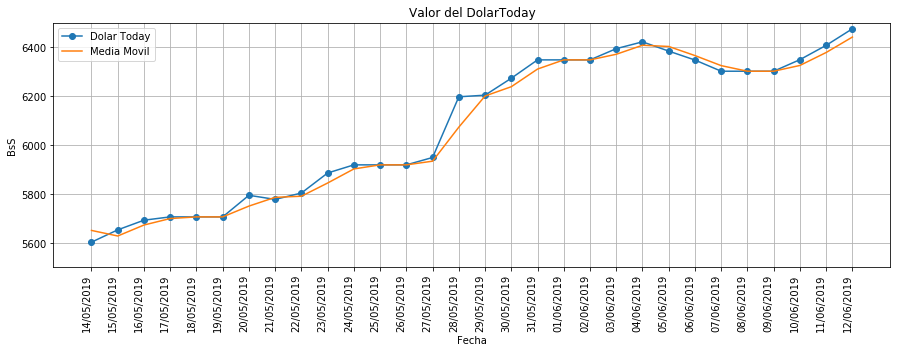

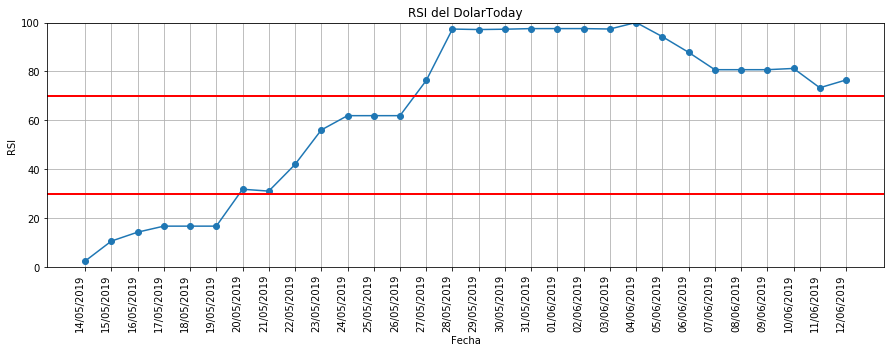

In [10]:
df6 = df5.iloc[len(df5)-n:]
df61 = df5.iloc[len(df5)-n-(n_MM-1):]

y1 = df6.loc[:,'DolarToday'].values
y2 = media_movil(df61.loc[:,'DolarToday'].values, n_MM)
x1 = df6.loc[:,'Fecha'].values

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x1, y1, 'o-')
ax.plot(x1, y2)

ax.legend(['Dolar Today','Media Movil'])

ax.set(xlabel='Fecha', ylabel='BsS',
       title='Valor del DolarToday')

ytop = np.floor(max(y1)/100+1)*100
ybottom = np.floor(min(y1)/100-1)*100

plt.ylim(ybottom, ytop)
fig.autofmt_xdate(rotation=90)

ax.grid()

df7 = df5.iloc[len(df5)-n:]

y2 = df7.loc[:,'RSI'].values
x2 = df7.loc[:,'Fecha'].values

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x2, y2, 'o-')

ax.set(xlabel='Fecha', ylabel='RSI',
       title='RSI del DolarToday')

ax.axhline(y = 70, color = "red", lw = 2)
ax.axhline(y = 30, color = "red", lw = 2)

ytop = 100
ybottom = 0

plt.ylim(ybottom, ytop)
fig.autofmt_xdate(rotation=90)
ax.grid()

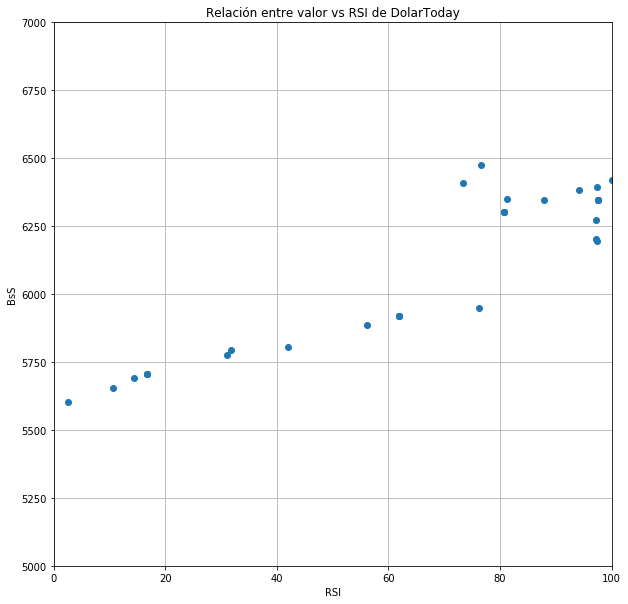

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y2, y1, 'o')

ax.set(xlabel='RSI', ylabel='BsS',
       title='Relación entre valor vs RSI de DolarToday')

ytop = np.floor(max(y1)/1000+1)*1000
ybottom = np.floor(min(y1)/1000)*1000

xtop = 100
xbottom = 0

plt.xlim(xbottom, xtop)
plt.ylim(ybottom, ytop)
ax.grid()

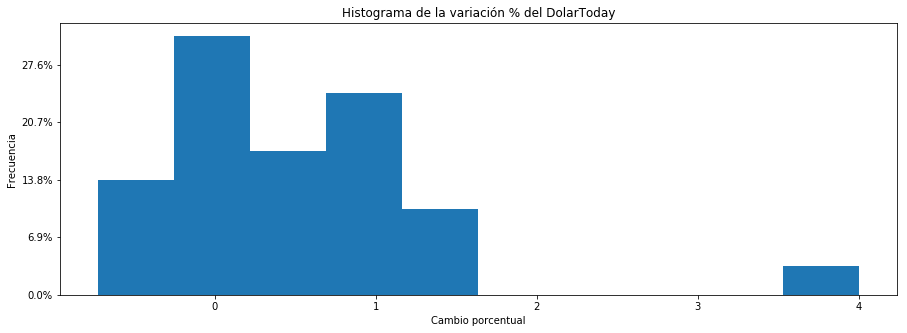

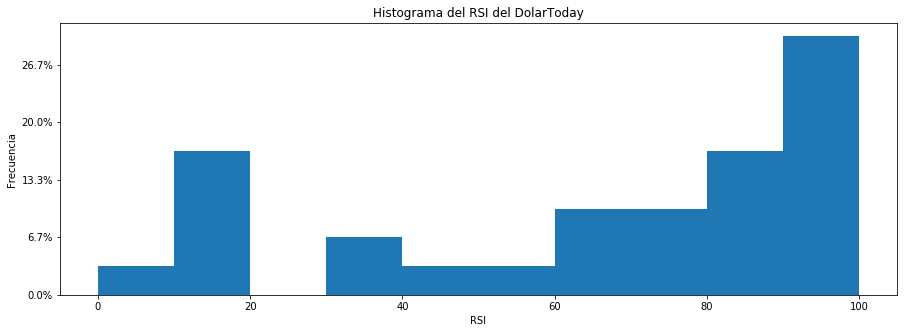

In [13]:
d1 = (df6[['DolarToday']].diff()/df6[['DolarToday']]*100).values

fig, bx = plt.subplots(figsize=(15, 5))

bx.set(xlabel='Cambio porcentual', ylabel='Frecuencia',
       title='Histograma de la variación % del DolarToday')

bx.yaxis.set_major_formatter(PercentFormatter(bx.hist(d1, bins=10, density=False)[0].sum()))

RSIval = df7['RSI']

fig, bx = plt.subplots(figsize=(15, 5))

bx.set(xlabel='RSI', ylabel='Frecuencia',
       title='Histograma del RSI del DolarToday')

bins = [0,10,20,30,40,50,60,70,80,90,100]

bx.yaxis.set_major_formatter(PercentFormatter(bx.hist(RSIval, bins, density=False)[0].sum()))

Estimación del valor del dolartoday

In [14]:
n_random = 100000
n_veces = 15 # Dias a ser referenciados

if n_veces > n:
    n_veces = n # Siempre menor que los dias ploteados

val1 = np.concatenate(([0], bx.hist(d1, bins=10, density=False)[0].cumsum()), axis=None)
val2 = bx.hist(d1, bins=10, density=False)[1]

x = np.zeros(n_random)
y = np.ones(n_random)
for j in range(n_veces):
    for i in range(n_random):
        val = rn.randrange(0,n-1)
        x[i] = val2[val1>=val][0]
    y = y * (1 + x/100)
    
dolarval = y*df6['DolarToday'].values[-1]

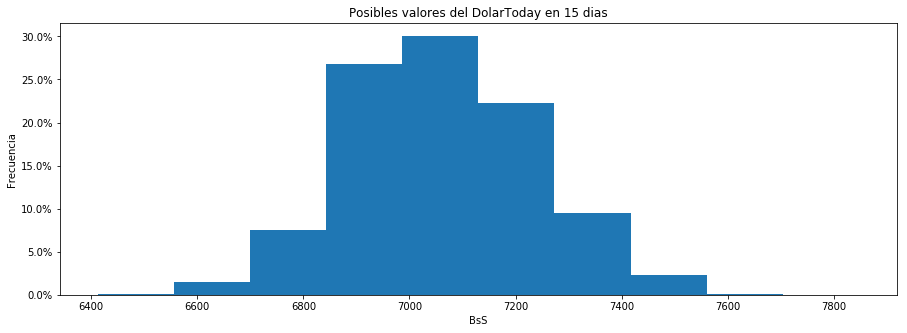

In [15]:
fig, bx = plt.subplots(figsize=(15, 5))

bx.set(xlabel='BsS', ylabel='Frecuencia',
       title='Posibles valores del DolarToday en ' + str(n_veces) + ' dias')

bx.yaxis.set_major_formatter(PercentFormatter(bx.hist(dolarval, bins=10, density=False)[0].sum()))

In [16]:
import scipy.stats as st

alpha = 0.95 # intervalo de confianza

z_value = st.norm.ppf(1-(1-alpha)/2)

FRDT= 1 #Factor entre el valor del dolar en la calle y el indicado por dolartoday

low_int = (dolarval.mean() - z_value * dolarval.std())*FRDT
high_int = (dolarval.mean() + z_value * dolarval.std())*FRDT

print("Con una confianza del " + str(alpha*100) + "% que el valor del dolartoday en " + str(n_veces) + " dias estará entre " + str(low_int.round(2)) 
      + " y " + str(high_int.round(2)))

print("El valor estimado del dolartoday en " + str(n_veces) + " dias es de " + str(dolarval.mean().round(2)))

Con una confianza del 95.0% que el valor del dolartoday en 15 dias estará entre 6725.73 y 7394.22
El valor estimado del dolartoday en 15 dias es de 7059.97


Estimación de la fuerza entre comprar y vender

In [17]:
#Peso del compra-venta * valor del RSI

bins = [0,9,18,27,36,45,54,63,72,81,90,100]

weight = bx.hist(RSIval.tail(n_veces), bins, density=False)[0] / bx.hist(RSIval.tail(n_veces), bins, density=False)[0].sum()

tier_1 = np.array([0,100])*weight[0]
tier_2 = np.array([10,90])*weight[1]
tier_3 = np.array([20,80])*weight[2]
tier_4 = np.array([30,70])*weight[3]
tier_5 = np.array([40,60])*weight[4]
tier_6 = np.array([50,50])*weight[5]
tier_7 = np.array([60,40])*weight[6]
tier_8 = np.array([70,30])*weight[7]
tier_9 = np.array([80,20])*weight[8]
tier_10 = np.array([90,10])*weight[9]
tier_11 = np.array([100,0])*weight[10]

tier = (tier_1 + tier_2 + tier_3 + tier_4 + tier_5 + tier_6 + tier_7 + tier_8 + tier_9 + tier_10) 

tier = tier / tier.sum() * 100

if tier[0] < 15:
    mensaje = 'Fuerte Comprar'
elif tier[0] < 30:
    mensaje = 'Comprar'
elif tier[0] < 40:
    mensaje = 'Pensar Comprar'
elif tier[0] < 60:
    mensaje = 'Mantener'
elif tier[0] < 70:
    mensaje = 'Pensar Vender'
elif tier[0] < 85:
    mensaje = 'Vender'
else:
    mensaje = 'Fuerte Vender'
    
print('Se recomienda tener la posición de: ' + mensaje)

Se recomienda tener la posición de: Vender


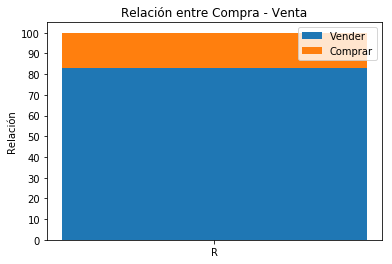

In [18]:
Vender = tier[0]
Comprar = tier[1]
ind = np.arange(1)    # the x locations for the groups

p1 = plt.bar(ind, Vender)
p2 = plt.bar(ind, Comprar, bottom=Vender)

plt.ylabel('Relación')
plt.title('Relación entre Compra - Venta')
plt.xticks(ind, ('Relación'))
plt.yticks(np.arange(0, 101, 10))
plt.legend((p1[0], p2[0]), ('Vender', 'Comprar'))
